In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import glob

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import time
from keras_tuner import HyperModel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch

In [2]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish_D1_I7000_F9000/TPath_500_finish_data_D1.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,500,7000,9000,669.05
1,0.0000,-0.00199,500,7000,9000,675.83
2,0.0000,-0.00198,500,7000,9000,682.81
3,0.0000,-0.00197,500,7000,9000,689.82
4,0.0000,-0.00196,500,7000,9000,696.80
...,...,...,...,...,...,...
100646,0.0025,0.00196,500,7000,9000,578.47
100647,0.0025,0.00197,500,7000,9000,576.89
100648,0.0025,0.00198,500,7000,9000,575.32
100649,0.0025,0.00199,500,7000,9000,573.76


In [3]:
df = data.drop(data.columns[2:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Temperatur
0,0.0000,-0.00200,669.05
1,0.0000,-0.00199,675.83
2,0.0000,-0.00198,682.81
3,0.0000,-0.00197,689.82
4,0.0000,-0.00196,696.80
...,...,...,...
100646,0.0025,0.00196,578.47
100647,0.0025,0.00197,576.89
100648,0.0025,0.00198,575.32
100649,0.0025,0.00199,573.76


In [4]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Temperatur
83145       0.00207      -0.00062      1282.2
66701       0.00166      -0.00065      1347.6
91325       0.00227       0.00098      1094.6
46593       0.00116      -0.00123      1175.7
49518       0.00123      -0.00005      1459.2
...             ...           ...         ...
6265        0.00015       0.00050      1439.1
54886       0.00136       0.00150       876.7
76820       0.00191       0.00029      1335.8
860         0.00002      -0.00142      1071.2
15795       0.00039      -0.00044      1488.1

[100651 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00207,-0.00062,1282.2
1,0.00166,-0.00065,1347.6
2,0.00227,0.00098,1094.6
3,0.00116,-0.00123,1175.7
4,0.00123,-0.00005,1459.2
...,...,...,...
100646,0.00015,0.00050,1439.1
100647,0.00136,0.00150,876.7
100648,0.00191,0.00029,1335.8
100649,0.00002,-0.00142,1071.2


In [5]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [6]:
X.describe()

,X-Koordinate,Y-Koordinate
count,100651.000000,1.006510e+05
mean,0.001250,1.103042e-20
std,0.000725,1.157589e-03
min,0.000000,-2.000000e-03
25%,0.000620,-1.000000e-03
50%,0.001250,4.529900e-18
75%,0.001880,1.000000e-03
max,0.002500,2.000000e-03


In [7]:
y.describe()


count    100651.000000
mean       1144.030064
std         264.135723
min         572.200000
25%         937.330000
50%        1201.100000
75%        1368.700000
max        1520.000000
Name: Temperatur, dtype: float64

In [8]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [9]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [10]:
X_train_scaled

array([[0.416 , 0.5725],
       [0.812 , 0.7325],
       [0.628 , 0.5075],
       ...,
       [0.604 , 0.3875],
       [0.748 , 0.65  ],
       [0.028 , 0.6225]])

In [11]:
# Lernplan erstellen
#initial_learning_rate = 0.1
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate, decay_steps=100, decay_rate=0.9, staircase=True)

In [38]:
start_time = time.time()
# Netzwerkarchitektur
model = Sequential([
    # Eingabeschicht
    Dense(32, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    #Dropout(0.01),
    # Versteckte Schicht
    Dense(96, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    #Dropout(0.01),
    # Ausgabeschicht für Regression (1 Einheit ohne Aktivierungsfunktion)
    Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True, min_delta = 0.00005)

# Trainingsparameter
batch_size = 50
epochs = 100

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose = 2)

end_time = time.time()

# Berechne die Dauer
duration = end_time - start_time

print(f"Die Ausführungszeit betrug {duration} Sekunden.")

Epoch 1/100
1289/1289 - 2s - loss: 0.0297 - mae: 0.0436 - val_loss: 0.0125 - val_mae: 0.0070 - 2s/epoch - 2ms/step
Epoch 2/100
1289/1289 - 1s - loss: 0.0100 - mae: 0.0082 - val_loss: 0.0081 - val_mae: 0.0118 - 1s/epoch - 884us/step
Epoch 3/100
1289/1289 - 1s - loss: 0.0066 - mae: 0.0078 - val_loss: 0.0053 - val_mae: 0.0107 - 1s/epoch - 885us/step
Epoch 4/100
1289/1289 - 1s - loss: 0.0043 - mae: 0.0069 - val_loss: 0.0035 - val_mae: 0.0085 - 1s/epoch - 883us/step
Epoch 5/100
1289/1289 - 1s - loss: 0.0028 - mae: 0.0065 - val_loss: 0.0023 - val_mae: 0.0062 - 1s/epoch - 894us/step
Epoch 6/100
1289/1289 - 1s - loss: 0.0019 - mae: 0.0063 - val_loss: 0.0019 - val_mae: 0.0146 - 1s/epoch - 880us/step
Epoch 7/100
1289/1289 - 1s - loss: 0.0014 - mae: 0.0062 - val_loss: 0.0012 - val_mae: 0.0046 - 1s/epoch - 891us/step
Epoch 8/100
1289/1289 - 1s - loss: 0.0011 - mae: 0.0062 - val_loss: 0.0010 - val_mae: 0.0056 - 1s/epoch - 901us/step
Epoch 9/100
1289/1289 - 1s - loss: 9.5248e-04 - mae: 0.0058 - val_

In [39]:
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[1000]} Actual: {original_actual_values[1000]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")
    
    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]
    
    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)
    
    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")


 Bsp. Predicted: [1171.5438] Actual: [1195.9] 
Durchschnittliche Abweichung (MAE): [11.38017216]


In [40]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list1], 'Vorhergesagt': [val[0] for val in list2]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]

df_result['Differenz'] = df_result['Echt'] - df_result['Vorhergesagt']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] < 10).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)
 
sorted_df

Anzahl der Werte die kleiner sind: 18041


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Differenz
13104,774.550171,812.70,1.000,0.0425,-38.149829
396,768.254333,806.10,1.000,0.0400,-37.845667
19881,799.277527,836.11,0.996,0.0525,-36.832473
15198,812.325317,848.92,1.000,0.0575,-36.594683
2783,767.342224,803.59,0.992,0.0400,-36.247776
...,...,...,...,...,...
321,632.305420,591.99,0.884,0.9750,40.315420
4134,631.888062,591.24,0.840,0.9750,40.648062
15061,628.228577,587.18,0.956,0.9775,41.048577
11939,628.304077,586.88,0.964,0.9775,41.424077


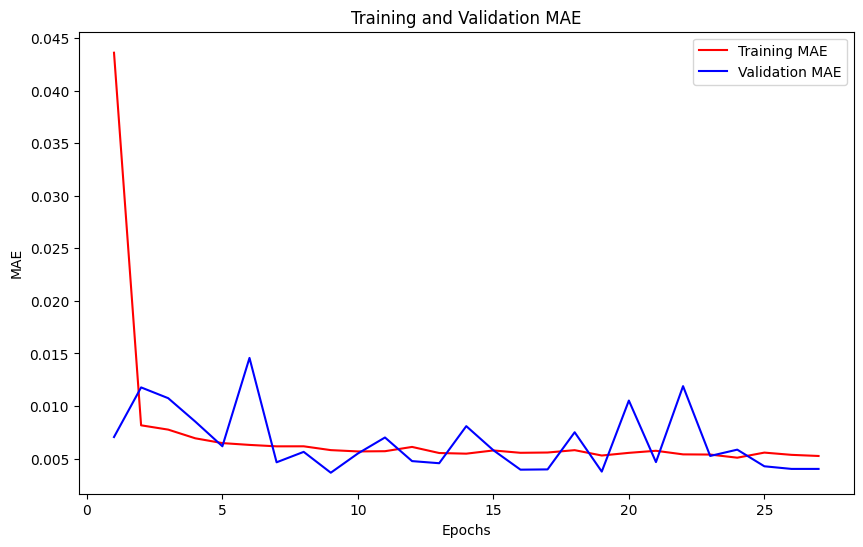

In [41]:
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(mae) + 1)
# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


# GridSearch
Grid Search bietet die Vorteile der anpassbaren Rechenzeit sowie die Möglichkeit des EInsatzes von Verteilungen. So können theoretisch Hyperparamterkonfuigurationen gefunden wende, welche durch GridSearch nicht auffindbar wären. ZUdem ist das Ziel der Hyperparamteroptimierung eine Einstellung zu finden, welche auf Trainings und Testset gut angepasst ist. Die EInstellung muss nicht die bestmöglichste Einstellung sein, sondern eine Einstellung die das gewähltre Problem gut wiederspiegelt. 
Bayesian Optimierung

In [ ]:
# Schritt 1: Definiere dein Modell als eine Funktion, die Hyperparameter akzeptiert
def build_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(units=32, activation=activation, input_dim=X_train_scaled.shape[1]))
    model.add(Dense(units=8, activation=activation))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Schritt 2: Erstelle eine Instanz von KerasRegressor ohne batch_size und epochs im param_grid
model = KerasRegressor(model=build_model, verbose=0)

# Schritt 3: Definiere den Parameter-Raum für die Grid-Suche OHNE batch_size und epochs
param_grid = {
    'model__optimizer': ['adam', 'sgd'],
    'model__activation': ['relu', 'sigmoid']
}

# Optional: Definiere Fit-Parameter (wie batch_size und epochs) separat
fit_params = {
    'batch_size': 32,
    'epochs': 100
}

# Schritt 4: Führe GridSearchCV aus mit fit_params, wenn nötig
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_scaled, y_train_scaled, **fit_params)

# Ergebnisse ausgeben
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean_score, params in zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['params']):
    print("%f with: %r" % (mean_score, params))


In [ ]:
def build_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(units=64, activation=activation, input_dim=X_train_scaled.shape[1]))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

model = KerasRegressor(model=build_model, verbose=1)

param_grid = {
    'model__optimizer': ['adam', 'sgd'],
    'model__activation': ['relu', 'tanh'],
    'fit__batch_size': [10, 20, 32, 50, 100],  # Testen verschiedener batch_size Werte
    'fit__epochs': [5, 10]  # Optional: Testen verschiedener epoch Werte
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# Ergebnisse ausgeben
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean_score, params in zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['params']):
    print("%f with: %r" % (mean_score, params))


In [37]:
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Dense(
            units=hp.Int('units_input', min_value=16, max_value=124, step=16),
            activation='relu',
            input_shape=self.input_shape,
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(0.0001)
        ))
        model.add(Dense(
            units=hp.Int('units_hidden1', min_value=16, max_value=124, step=16),
            activation='relu',
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(0.0001)
        ))
        model.add(Dense(
            units=hp.Int('units_hidden2', min_value=16, max_value=124, step=16),
            activation='relu',
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(0.0001) 
        ))
        model.add(Dense(1, activation='linear'))

        model.compile(
            optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='mean_squared_error',
            metrics=['mae']
        )
        return model

# Setzen Sie die richtige Eingabeform hier, z.B. (2,)
hypermodel = RegressionHyperModel(input_shape=(2,))

tuner = RandomSearch(
    hypermodel,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_tuner_demo4'
)

# Beachten Sie, dass X_train_scaled, y_train_scaled durch Ihre tatsächlichen Trainingsdaten ersetzt werden müssen.
tuner.search(X_train_scaled, y_train_scaled, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Die besten Hyperparameter bekommen
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Die besten Hyperparameter sind: {best_hps.values}")

# Das beste Modell mit den optimalen Hyperparametern trainieren
#model = tuner.hypermodel.build(best_hps)
# Hier müssen Sie die tatsächlichen Trainings- und Validierungsdaten einfügen
#history = model.fit(X_train_scaled, y_train_scaled, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Trial 20 Complete [00h 00m 46s]
val_mae: 0.005825335392728448

Best val_mae So Far: 0.0035446375841274858
Total elapsed time: 00h 15m 04s
Die besten Hyperparameter sind: {'units_input': 32, 'units_hidden1': 96, 'units_hidden2': 32, 'learning_rate': 0.001}


In [16]:
from bayes_opt import BayesianOptimization


# Angenommene Daten
# X_train_scaled, y_train_scaled = # Deine skalierten Trainingsdaten

def train_evaluate(neurons_layer_1, neurons_layer_2, neurons_layer_3, learning_rate):
    model = Sequential([
        Dense(int(neurons_layer_1), activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_2), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        
        Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True, min_delta=0.0001)

    history = model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Hier wählen wir den negativen Mean Squared Error, da Bayesian Optimization maximiert
    mse = np.min(history.history['val_loss'])
    return -mse

# Definieren des Bereichs der Hyperparameter
pbounds = {
    'neurons_layer_1': (16, 128),
    'neurons_layer_2': (16, 128),
    'neurons_layer_3': (16, 128),
    'learning_rate': (0.0001, 0.01),
}

# Initialisieren des BayesianOptimization-Objekts
optimizer = BayesianOptimization(
    f=train_evaluate,
    pbounds=pbounds,
    random_state=1,
)

# Starten der Optimierung
optimizer.maximize(init_points=2, n_iter=20)

print(optimizer.max)


|   iter    |  target   | learni... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------
Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping
| 1         | -0.000574 | 0.004229  | 96.68     | 16.01     | 49.86     |
Restoring model weights from the end of the best epoch: 11.
Epoch 16: early stopping
| 2         | -0.000625 | 0.001553  | 26.34     | 36.86     | 54.7      |
Restoring model weights from the end of the best epoch: 12.
Epoch 17: early stopping
| 3         | -0.000540 | 0.003015  | 95.56     | 18.41     | 50.67     |
Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping
| 4         | -0.000718 | 0.006143  | 95.07     | 17.42     | 52.76     |
Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
| 5         | -0.000624 | 0.006272  | 41.0      | 123.4     | 106.1     |
Restoring model weights from the end of the best epoch: 23.
